In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [4]:
f=r'Desktop/default_credit_b.csv'
data = pd.read_csv(f)
print('成功读取数据共{} '.format(data.shape))
data.head()

成功读取数据共(30000, 15) 


,id,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,25115,1,-1.486041,-0.695628,-0.682385,-0.674713,-0.675078,-0.672187,-0.668576,-0.281506,-0.256946,-0.296744,-0.307999,-0.314071,-0.293326
1,2346,0,-0.616452,-0.418693,-0.411269,-0.385059,-0.429740,-0.659456,-0.632490,-0.255907,0.624502,-0.238869,-0.294083,-0.235265,-0.287251
2,2613,0,-1.486041,-0.695642,-0.690983,-0.483273,-0.531385,-0.481978,-0.549086,-0.341942,0.328892,0.221014,0.394674,0.089842,-0.244499
3,15473,0,0.253137,-0.643723,1.413661,0.138401,0.530734,0.641564,0.589780,8.732378,0.203808,1.123115,-0.114393,-0.116991,-0.011447
4,12900,0,-1.486041,-0.580438,-0.557140,-0.190706,-0.672777,-0.663355,-0.653026,0.233558,1.209473,-0.296801,-0.308063,-0.314136,-0.293382


In [197]:
data['y'].value_counts()

0    23364
1     6636
Name: y, dtype: int64

In [5]:
data_x = data[data.columns[2:]]
data_y = data[data.columns[1]]

In [231]:
clf=GaussianMixture(n_components=3,covariance_type='full', tol = 1e-5, random_state=0)
clf.fit(data_x)
result=clf.predict(data_x)

In [232]:
result

array([2, 1, 1, ..., 2, 2, 0], dtype=int64)

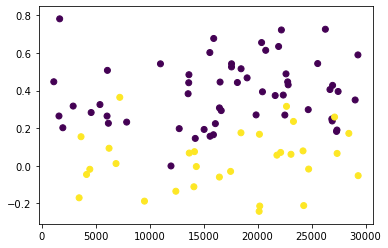

In [219]:
plt.scatter(data.iloc[:,0],data.iloc[:,3],c=result)

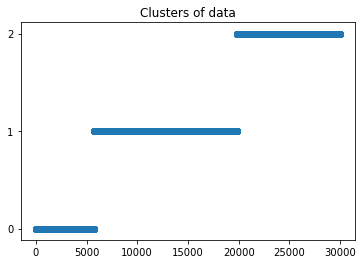

In [8]:
def plot_clusters(x, K):
    x.sort()
    plt.scatter(range(len(x)),x)
    plt.yticks(range(K))
    plt.title('Clusters of data')
plot_clusters(result,3)

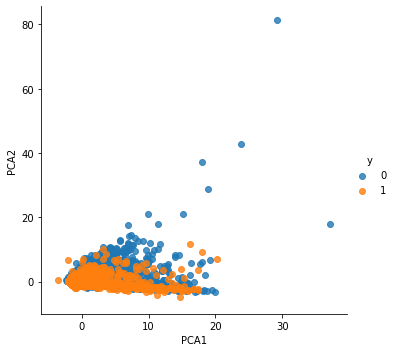

In [9]:
from sklearn.decomposition import PCA
model=PCA(n_components=2)
model.fit(data_x)
X_2d = model.transform(data_x)
data['PCA1'] = X_2d[:,0]
data['PCA2'] = X_2d[:,1]
sns.lmplot('PCA1','PCA2',data=data,hue='y',fit_reg=False)

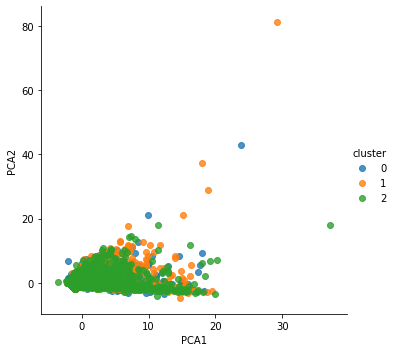

In [10]:
from sklearn.decomposition import PCA
model=PCA(n_components=2)
model.fit(data_x)
X_2d = model.transform(data_x)
data['PCA1'] = X_2d[:,0]
data['PCA2'] = X_2d[:,1]
data['cluster'] = result
sns.lmplot('PCA1','PCA2',data=data,hue='cluster',fit_reg=False)

In [13]:
# 主函数
def update_prob(prob, input_data,lamb, para, k):
    '''
    更新GMM的 状态转移矩阵prob
    :param prob: 状态转移矩阵prob，NxK
    :param lamb: 分布向量  ##每个模型比例的先验概率
    :param para: 关于数据分布的参数
    :param k: clusters 的数量
    :return: 返回状态转移矩阵prob
    '''
    for j in range(0, k):
        tmp = multivariate_normal.pdf(input_data, para[0][j], para[1][j])
        prob.iloc[:, j] = lamb[j] * tmp
        #converg_flag = math.log(prob.sum(axis=1).sum())
    return prob.apply(lambda x: x / prob.sum(axis=1))#,converg_flag


def update_para(prob, input_data, lamb, para, n, k):
    para[0] = [prob.iloc[:, j].values.dot(input_data.values) / (n * lamb[j]) for j in range(k)]
    # poisson distr OR gaussian distr
    if len(para) == 2:
        l = []
        for j in range(k):
            tmp = input_data.values - para[0][j]
            tmp = (tmp.T * prob.iloc[:, j].values).dot(tmp)/ (n * lamb[j])
            # tmp = np.diag(prob.iloc[:,j].values.dot(tmp**2)/(n*lamb[j]))
            #tmp = np.linalg.inv(tmp)
            l.append(tmp)
            para[1] = np.array(l)
    return [np.nan_to_num(arr) for arr in para]


def meet_requrement(lamb, threshold=1e-3):
    if any([p < threshold for p in lamb]): return True
    return False


def EM(k, input_data, max_step, threshold, paras):
    '''
    多维特征的EM聚类
    :param k: 聚类数量
    :param input_data: 数据
    :param max_step: 最大迭代次数
    :param threshold: 误差阈值
    :return: 股票代码及其所属类
    '''
    n = input_data.shape[0]
    d = input_data.shape[1]
    losses = []

    ##initial probability distribution vector
    lamb = np.repeat(1 / k, k)
    ##initial probability matrix
    prob = pd.DataFrame(np.zeros((n, k)))
    print('Start training! prob:', prob.shape)
    
    
    ##start iteration
    for step in range(0, max_step):
        losses.append(lamb[2])
        # show process
        if (step) % 2 == 0:
            print()
            print('# Step:{} lamb:{}'.format(step, lamb))

        ##E-step: find the probability of x_i belonging to j group
        #

        prob = update_prob(prob, input_data, lamb, paras, k)

        ##find the expectation of lambda
        lamb = prob.mean(axis=0).values
    
        ##M-step: maximize the pivotal function == MLE of normal distribution
        paras = update_para(prob, input_data, lamb, paras, n, k)
        
        ##stop condition
        if meet_requrement(lamb, threshold): break
    return prob.apply(lambda x: np.argmax(x), axis=1), losses, paras

## 初始化的归纳函数
def init_mu_minmax(k,d):
    return np.array([np.random.uniform(input_data.min(), input_data.max()) for _ in range(k)])

def init_mu_stats(k,d):
    return np.array([[np.random.uniform(i*80, i*120) for i in input_data.median()[:d]] for _ in range(k)])

def init_mu_random(k,d):
    return np.array([input_data.iloc[ind] for ind in np.random.choice(len(input_data),size = k,replace=False)])

def init_sigma(k,d):
    return np.array([np.diag([np.random.uniform(abs(i), i**2) for i in input_data.max()]) for _ in range(k)])


# 初始化para
def init_para(k,d,type_='gaussian'):
    para = [np.random.rand(k, d)]
    if type_ == 'gaussian':
        para.append(np.array([np.eye(d)]* k))
    return para


In [14]:
input_data = data_x.iloc[:200,:]
threshold = 1e-13
max_step=100
k=3
n = input_data.shape[0]
d = input_data.shape[1]
prob = pd.DataFrame(np.zeros((n, k)))
lamb = np.repeat(1 / k, k)
lamb

array([0.33333333, 0.33333333, 0.33333333])

In [15]:
def scale_data(Y):
    # 对每一维特征分别进行缩放
    for i in range(Y.shape[1]):
        max_ = Y.iloc[:, i].max()
        min_ = Y.iloc[:, i].min()
        Y.iloc[:, i] = (Y.iloc[:, i] - min_) / (max_ - min_)
    input_data = Y
    return input_data
scale_data(input_data)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.0,0.265238,0.020462,0.024383,0.007729,0.007005,0.005997,0.004448,0.000005,0.000007,0.000009,0.000006,0.000011
1,0.2,0.300139,0.063685,0.068214,0.042743,0.008757,0.010760,0.006331,0.102560,0.007440,0.001870,0.006964,0.001211
2,0.0,0.265237,0.019092,0.053352,0.028237,0.033177,0.021769,0.000000,0.068166,0.066498,0.094025,0.035671,0.009656
3,0.4,0.271780,0.354627,0.147426,0.179820,0.187775,0.172088,0.667795,0.053613,0.182347,0.025913,0.017408,0.055689
4,0.0,0.279755,0.040430,0.097624,0.008057,0.008220,0.008050,0.042352,0.170620,0.000000,0.000000,0.000000,0.000000
5,0.4,0.375919,0.172697,0.180677,0.174425,0.196423,0.121959,0.022216,0.025249,0.036469,0.085407,0.028897,0.055556
6,0.4,0.533729,0.365962,0.357616,0.343077,0.345702,0.334551,0.048875,0.055547,0.080233,0.093948,0.063574,0.122222
7,0.0,0.265237,0.019092,0.023896,0.008097,0.008261,0.008090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.8,0.466152,0.286498,0.290095,0.282085,0.290216,0.290528,0.023993,0.030298,0.036469,0.039287,0.028897,0.056667
9,0.4,0.328398,0.096085,0.107898,0.091467,0.096121,0.096063,0.007109,0.033833,0.000000,0.017081,0.009825,0.015556


In [16]:
para = init_para(k,d,type_='gaussian')
para

[array([[0.91999662, 0.54855494, 0.28271634, 0.09792459, 0.16216107,
         0.95505287, 0.26242505, 0.04690611, 0.09192611, 0.23642702,
         0.35246872, 0.44560784, 0.88314086],
        [0.17908945, 0.80029257, 0.73887799, 0.49179933, 0.16796206,
         0.52388466, 0.92391026, 0.6534163 , 0.13059491, 0.94512919,
         0.32756422, 0.15481464, 0.40786392],
        [0.80294822, 0.55028229, 0.69180274, 0.64462447, 0.75690425,
         0.14993495, 0.1436889 , 0.54406013, 0.77608557, 0.03203253,
         0.37148484, 0.46896615, 0.58929328]]),
 array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
     

In [10]:
a,losses,paras = EM(k, input_data,100, threshold, para)

Start training! prob: (200, 3)

# Step:0 lamb:[0.33333333 0.33333333 0.33333333]

# Step:2 lamb:[0.13630886 0.1675379  0.69615324]

# Step:4 lamb:[0.11982773 0.13180031 0.74837195]

# Step:6 lamb:[0.12584586 0.1772742  0.69687994]

# Step:8 lamb:[0.13771241 0.21257942 0.64970817]

# Step:10 lamb:[0.13568165 0.25858558 0.60573277]

# Step:12 lamb:[0.12547147 0.29635691 0.57817162]

# Step:14 lamb:[0.12459789 0.32211415 0.55328795]

# Step:16 lamb:[0.12498055 0.33869745 0.536322  ]

# Step:18 lamb:[0.12533826 0.35272535 0.5219364 ]

# Step:20 lamb:[0.12579984 0.35797405 0.51622611]

# Step:22 lamb:[0.12725076 0.3601197  0.51262954]

# Step:24 lamb:[0.12889084 0.36692705 0.50418212]

# Step:26 lamb:[0.12906141 0.37709939 0.4938392 ]

# Step:28 lamb:[0.12833852 0.3829618  0.48869968]

# Step:30 lamb:[0.12718313 0.38429499 0.48852188]

# Step:32 lamb:[0.1260605  0.38540308 0.48853643]

# Step:34 lamb:[0.12574285 0.38571679 0.48854037]

# Step:36 lamb:[0.12570064 0.38575751 0.48854185]

# St

C:\Users\Joy\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [11]:
a = np.array(a)

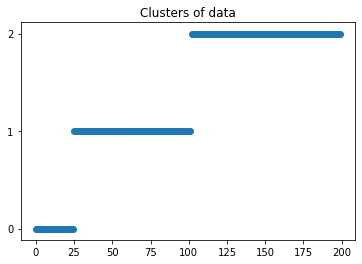

In [12]:
def plot_clusters(x, K):
    x.sort()
    plt.scatter(range(len(x)),x)
    plt.yticks(range(K))
    plt.title('Clusters of data')
plot_clusters(a,3)